In [1]:
import warnings
warnings.filterwarnings('ignore')

#### Importing Required Libraries

In [19]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
import wordcloud
from keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import re

#### Load the dataset and creating a new column sentiment

In [4]:
import pandas as pd
#Loading the dataset
data = pd.read_csv('C:\\Users\\dhara\\Downloads\\amazon_alexa.tsv',sep='\t')
print(data.head())

# Creating a new column sentiment based on overall ratings
def sentiments(df):
    if df['rating'] > 3.0:
        return 'Positive'
    elif df['rating'] <= 3.0:
        return 'Negative'
data['sentiment'] = data.apply(sentiments, axis=1)

   rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1  


#### checking for null values

In [5]:
#Check if there are any null values
data_ = data[['verified_reviews','sentiment']]
data_.isnull().sum()

verified_reviews    1
sentiment           0
dtype: int64

In [6]:
# Fill null values in verified_reviews with empty strings
data_['verified_reviews'] = data_['verified_reviews'].fillna('No Review')

In [7]:
data_['verified_reviews'] = data_['verified_reviews'].astype(str)

#### cleaning the data

In [8]:
def cleaning(df, stop_words):

    df['verified_reviews'] = df['verified_reviews'].apply(lambda x:' '.join(x.lower() for x in x.split()))

    # Replacing the special characters

    df['verified_reviews'] = df['verified_reviews'].str.replace(r'[^a-zA-Z\s]', '',regex=True)
    
    # Replacing the digits/numbers

    df['verified_reviews'] = df['verified_reviews'].str.replace(r'\d', '',regex=True)

    # Removing stop words

    df['verified_reviews'] = df['verified_reviews'].apply(lambda x:' '.join(x for x in x.split() if x not in stop_words))

    
   # Lemmatization

    df['verified_reviews'] = df['verified_reviews'].apply(lambda x:' '.join([Word(x).lemmatize() for x in x.split()]))

    return df

stop_words = stopwords.words('english')

data_ = cleaning(data_, stop_words)

In [9]:
data_.head()

,verified_reviews,sentiment
0,love echo,Positive
1,loved,Positive
2,sometimes playing game answer question correct...,Positive
3,lot fun thing yr old learns dinosaur control l...,Positive
4,music,Positive


#### Visualizing the common words in the reviews

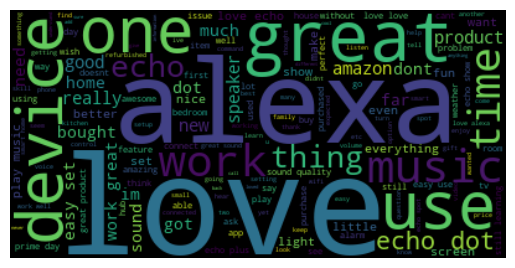

In [10]:
common_words=''
for i in data_.verified_reviews:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Encoding the target variable

In [11]:
# Encoded the target column
lb=LabelEncoder()
data_['sentiment'] = lb.fit_transform(data_['sentiment'])

#### Tokenize and converting the reviews into numerical vectors

In [12]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(data_['verified_reviews'].values)
X = tokenizer.texts_to_sequences(data_['verified_reviews'].values)
X = pad_sequences(X)

In [13]:
X.shape[1]

171

#### Num_words – This hyperparameter refers to the number of words to keep based on the frequency of words.
#### Split – This hyperparameter refers to the separator used for splitting the word.
#### pad_sequence() function is used to convert a list of sequences into a 2D NumPy array.

#### Building the LSTM Model

In [15]:
vocab_size = 1000      # Vocabulary size
embedding_dim = 128    # Dimension of embedding vectors
max_len = 171          # Length of input sequences

model =  Sequential()
model.add(Embedding(1000,128,input_length =max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.build(input_shape=(None, max_len))
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 171, 128)       │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 171, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,842 (1015.01 KB)

 Trainable params: 259,842 (1015.01 KB)

 Non-trainable params: 0 (0.00 B)

None


#### splitting the data into training and testing

In [16]:
#Splitting the data into training and testing
y=pd.get_dummies(data_['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

#### Train the model

In [17]:
batch_size=32
model.fit(X_train, y_train, epochs = 5, batch_size=batch_size, verbose = 'auto')

Epoch 1/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 32s 326ms/step - accuracy: 0.8292 - loss: 0.4355
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 21s 308ms/step - accuracy: 0.8853 - loss: 0.2930
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 22s 311ms/step - accuracy: 0.9201 - loss: 0.2105
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 21s 300ms/step - accuracy: 0.9170 - loss: 0.1857
Epoch 5/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 20s 291ms/step - accuracy: 0.9419 - loss: 0.1566


#### Evaluate the model

In [18]:
model.evaluate(X_test,y_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8994 - loss: 0.2292


[0.23456288874149323, 0.908994734287262]

#### Confusion Matrix and Classification Report

In [20]:
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.values.argmax(axis=1)

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes))


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step
[[ 68  67]
 [ 19 791]]
              precision    recall  f1-score   support

           0       0.78      0.50      0.61       135
           1       0.92      0.98      0.95       810

    accuracy                           0.91       945
   macro avg       0.85      0.74      0.78       945
weighted avg       0.90      0.91      0.90       945

